## Автор: Шкунков Арсений

Выражаю благодарность Игорю Дьяченко за примеры и парсер для них.

In [1]:
!git clone https://github.com/Ryzhtus/datavizmipt

Cloning into 'datavizmipt'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 65 (delta 29), reused 60 (delta 24), pack-reused 0
Unpacking objects: 100% (65/65), done.


In [2]:
!pip install python-sat

     |████████████████████████████████| 1.8MB 14.0MB/s 


In [3]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np

from itertools import combinations, chain
from pysat.solvers import Solver

In [4]:
class Pos:
    def __init__(self, *arr):
        assert len(arr) == 2
        self.xy = arr
    
    def __add__(self, that):
        return Pos(*[a + b for a, b in zip(self.xy, that.xy)])
    
    def __sub__(self, that):
        return Pos(*[a - b for a, b in zip(self.xy, that.xy)])
    
    def __neg__(self):
        return Pos(*[-a for a in self.xy])
    
    def __str__(self):
        return str(self.xy)
    
    def __repr__(self):
        return str(self)
    
    def parse(s):
        arr = [int(a) for a in s.split(',')]
        return Pos(*arr)

class Box:
    def __init__(self, line, idx):
        arr = line.split('\t')
        self.box_id = idx
        self.pos = Pos.parse(arr[0])
        self.size = Pos.parse(arr[1])
        self.offsets = [Pos.parse(pos) for pos in arr[2].split(' ')]
        self.offset_ids = [self.box_id + idx + 1 for idx in range(len(self.offsets))]
        self.id2offset = {idx: offset for idx, offset in zip(self.offset_ids, self.offsets)}
        assert len(self.offsets) > 0

    def __str__(self):
        return 'Box(id={}, pos={}, size={}, offsets={}, ids={})'.format(self.box_id, self.pos, self.size, self.offsets, self.offset_ids)
    
    def __repr__(self):
        return str(self)

    def make_condictions_for_box(self):
        conditions = []
        possible_combinations = [0] + [idx for idx in range(2, len(self.offset_ids) + 1)]
        subsets = chain.from_iterable(combinations([idx for idx in range(len(self.offset_ids))], combination) for combination in possible_combinations)
        for subset in subsets:
            conditions.append([-x if idx in subset else x for idx, x in enumerate(self.offset_ids)])
            
        return conditions

class Bound:
    def __init__(self, pos, size):
        self.x = pos[0]
        self.y = pos[1]
        self.width = size[0]
        self.height = size[1]
        self.bottom_left_x = self.x
        self.bottom_left_y = self.y
        self.top_right_x = self.x + self.width
        self.top_right_y = self.y + self.height

    def __repr__(self):
        return 'Bound(pos={}, size={}, bottom_left={}, top_right={}'.format((self.x, self.y), (self.width, self.height), (self.bottom_left_x, self.bottom_left_y), (self.top_right_x, self.top_right_y))

In [5]:
def calculate_box_parameters(box, offset_id=None):
    if offset_id:
        coordinates = (box.pos.xy[0] - box.id2offset[offset_id].xy[0], box.pos.xy[1] - box.id2offset[offset_id].xy[1])
        return Bound(coordinates, box.size.xy)
    else:
        return Bound(box.pos.xy, box.size.xy)

def check_intersection(box_a: Bound, box_b: Bound):
    return (box_a.top_right_x < box_b.bottom_left_x
                or box_a.bottom_left_x > box_b.top_right_x
                or box_a.top_right_y < box_b.bottom_left_y
                or box_a.bottom_left_y > box_b.top_right_y)

def make_conditions_for_intersections(boxes):
    conditions = []

    for i in range(len(boxes) - 1):
        for j in range(i + 1, len(boxes)):
            for offset_i in range(len(boxes[i].offset_ids)):
                condition = [-boxes[i].offset_ids[offset_i]]
                for offset_j in range(len(boxes[j].offset_ids)):
                    bounds_i = calculate_box_parameters(boxes[i], offset_id=boxes[i].offset_ids[offset_i])
                    bounds_j = calculate_box_parameters(boxes[j], offset_id=boxes[j].offset_ids[offset_j])
                    if check_intersection(bounds_i, bounds_j):
                        condition.append(boxes[j].offset_ids[offset_j])

                if len(condition) < len(boxes[j].offset_ids) + 1:
                    conditions.append(condition)

    return conditions

def collect_conditions(boxes):
    conditions = []

    # кодируем 1 положение прямоугольника в каждом из возможных вариантов его расположений
    for box in boxes:
        conditions += box.make_condictions_for_box()

    # кодируем позиции относительно пересечений прямоугольника с другими
    conditions += make_conditions_for_intersections(boxes)

    return conditions

def draw(boxes: Box) -> None:
    px = 1/plt.rcParams['figure.dpi']
    plt.figure(figsize=(500*px, 500*px))
    
    ax = plt.gca()
    
    x, y = [], []
    for box in boxes: 
        x.append(box.pos.xy[0])
        y.append(box.pos.xy[1])
    
    ax.scatter(x, y)

    for idx, box in enumerate(boxes):
        ax.add_patch(patches.Rectangle(box.pos.xy, box.size.xy[0], box.size.xy[1], edgecolor='black'))

    plt.axis('off')
    plt.show()

In [6]:
with open('/content/datavizmipt/3. LabelPlacement/examples/hard1.txt', 'r') as file:
    idx = 0
    boxes = []
    offset2box = {}
    for line in file.readlines():
        box = Box(line, idx)
        boxes.append(box)
        idx_end = max(box.offset_ids)
        for i in range(idx + 1, idx_end + 1):
            offset2box[i] = idx
        idx = idx_end + 1
        
    id2box = {box.box_id: idx for idx, box in enumerate(boxes)}

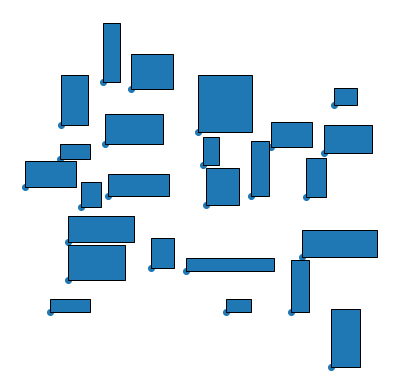

In [7]:
solver = Solver()
conditions = collect_conditions(boxes)

for condition in conditions:
    solver.add_clause(condition)

if solver.solve() == True:
    solution = np.array(solver.get_model())

    placement = []
    for idx in solution[solution > 0]:
        box = boxes[id2box[offset2box[idx]]]
        box.pos -= boxes[id2box[offset2box[idx]]].id2offset[idx]
        placement.append(box)

    draw(placement)

else:
    print('Нет решения')